In [1]:
import torch
import torch.nn as nn

In [2]:
class QvalueNetwork(nn.Module):
    def __init__(
        self,
        hidden_sizes,
        input_size_state,
        input_size_action,
        init_w=3e-3,
        activation=torch.relu
    ):
        super().__init__()

        self.hidden_sizes = hidden_sizes
        input_size = input_size_action + input_size_state

        self.input_size = input_size
        output_size = 1

        self.activation = activation

        inp_size = input_size
        self._layers = []
        for i, out_size in enumerate(self.hidden_sizes):
            layer = nn.Linear(inp_size, out_size)
            self._layers.append(layer)
            inp_size = out_size

        self.last_layer = nn.Linear(inp_size, output_size)

    def forward(self, state, action):
        input = torch.cat((state, action), dim=-1)

        for layer in self._layers:
            output = layer(input)
            output = self.activation(output)
            input = output

        output = self.last_layer(input)

        return output


class PolicyNetwork(nn.Module):
    def __init__(
        self,
        hidden_sizes,
        output_size,
        input_size,
        init_w=3e-3,
        activation=torch.relu
    ):
        super().__init__()

        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.input_size = input_size

        self.activation = activation

        inp_size = input_size
        self._layers = []
        for i, out_size in enumerate(self.hidden_sizes):
            layer = nn.Linear(inp_size, out_size)
            self._layers.append(layer)
            inp_size = out_size

        self.last_layer = nn.Linear(inp_size, output_size)

    def forward(self, state):
        input = state

        for layer in self._layers:
            output = layer(input)
            output = self.activation(output)
            input = output

        output = self.last_layer(input)
        output = torch.tanh(output)
        return output

class MessageNetwork(nn.Module):
    def __init__(
        self,
        hidden_sizes,
        output_size,
        input_size,
        init_w=3e-3,
        activation=torch.relu
    ):
        super().__init__()

        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.input_size = input_size

        self.activation = activation

        inp_size = input_size
        self._layers = []
        for i, out_size in enumerate(self.hidden_sizes):
            layer = nn.Linear(inp_size, out_size)
            self._layers.append(layer)
            inp_size = out_size

        self.last_layer = nn.Linear(inp_size, output_size)

    def forward(self, state):
        input = state

        for layer in self._layers:
            output = layer(input)
            output = self.activation(output)
            input = output

        output = self.last_layer(input)
        output = torch.tanh(output)
        return output

In [3]:
test = QvalueNetwork([200,200], 2, 2)
test_state = a = torch.randn(5, 2, dtype=torch.float32)
test(test_state, test_state)


tensor([[-0.0087],
        [-0.0739],
        [-0.0718],
        [-0.0580],
        [-0.0807]], grad_fn=<AddmmBackward>)

In [4]:
test_policy = PolicyNetwork([200,200], 2, 2)
test_policy(test_state)

tensor([[ 0.0714,  0.0080],
        [ 0.0627,  0.0290],
        [ 0.0568,  0.0162],
        [ 0.0258, -0.0194],
        [ 0.0603,  0.0247]], grad_fn=<TanhBackward>)

Test Pybullet Env


In [5]:
import pybullet
import pybullet_envs
import gym
import numpy as np
import time

In [6]:
env = gym.make('HalfCheetahBulletEnv-v0')
state = env.reset()
state = env.step(np.random.uniform(-1,1,size=6))

/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
state

(array([ 7.7637396e-04,  0.0000000e+00,  1.0000000e+00,  1.3323595e-02,
         0.0000000e+00,  3.7451446e-02,  0.0000000e+00, -2.1979457e-03,
        -2.8491670e-01,  1.2014151e-01, -4.8901629e-02, -1.0379118e-01,
        -2.6211509e-01, -5.9825581e-01,  2.9288933e-01, -2.1395943e-01,
         7.0723198e-02,  6.0370588e-01,  1.1347100e+00, -3.6393487e-01,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00], dtype=float32),
 0.6853017254471632,
 False,
 {})

Set up a simple graph

In [8]:
import dgl

Using backend: pytorch


In [56]:
g = dgl.DGLGraph()
g.add_nodes(7)
edge_list = [(0,1), (1,2), (2,3), (0,4), (4,5), (5,6)]
src, dst = tuple(zip(*edge_list))
g.add_edges(src, dst)

/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


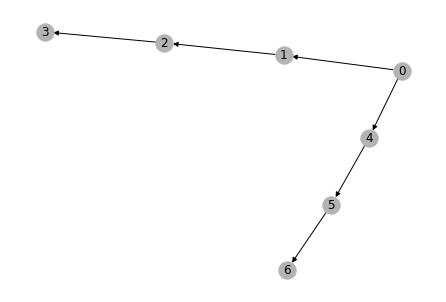

In [57]:
import networkx as nx
nx_G = g.to_networkx()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [32]:
def update_states_in_graph(state, graph):
    state_size = state.shape
    if len(state_size) == 1:
        state = np.expand_dims(state, 0)
        state_size = state.shape
    batch_size = state_size[0]
    root_state = np.expand_dims(np.array(state[:, 0:8]), 0)
    joint_states = np.array(state[:, 8:(8+2*6)]).reshape((6, batch_size, 2))
    graph.nodes[0].data['root_state'] = torch.from_numpy(root_state)
    graph.nodes[list(range(1,7))].data['state'] = torch.from_numpy(joint_states)

In [61]:
a = state[0][np.newaxis, ...]
print(a)
print('***')
root_state = np.array(a[:, 0:8])[np.newaxis, ...]
print(root_state)
print('***')
joint_states = np.array(a[:, 8:(8+2*6)]).reshape((6, 1, 2))
print(joint_states)
print('***')
g.nodes[0].data['root_state'] = torch.from_numpy(root_state)
g.nodes[list(range(1,7))].data['state'] = torch.from_numpy(joint_states)

[[ 7.7637396e-04  0.0000000e+00  1.0000000e+00  1.3323595e-02
   0.0000000e+00  3.7451446e-02  0.0000000e+00 -2.1979457e-03
  -2.8491670e-01  1.2014151e-01 -4.8901629e-02 -1.0379118e-01
  -2.6211509e-01 -5.9825581e-01  2.9288933e-01 -2.1395943e-01
   7.0723198e-02  6.0370588e-01  1.1347100e+00 -3.6393487e-01
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
***
[[[ 7.7637396e-04  0.0000000e+00  1.0000000e+00  1.3323595e-02
    0.0000000e+00  3.7451446e-02  0.0000000e+00 -2.1979457e-03]]]
***
[[[-0.2849167   0.12014151]]

 [[-0.04890163 -0.10379118]]

 [[-0.2621151  -0.5982558 ]]

 [[ 0.29288933 -0.21395943]]

 [[ 0.0707232   0.6037059 ]]

 [[ 1.13471    -0.36393487]]]
***


In [64]:
print(g.nodes[2].data)

{'root_state': tensor([[[ 7.7637e-04,  0.0000e+00,  1.0000e+00,  1.3324e-02,  0.0000e+00,
           3.7451e-02,  0.0000e+00, -2.1979e-03]]]), 'state': tensor([[[0., 0.]]])}


In [ ]:
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h_out']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h_in' : torch.sum(nodes.mailbox['msg'], dim=1)}

def gcn_message_trainer(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h_out'], 'msg_t': edges.src['h_out_t']}

def gcn_reduce_trainer(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h_in' : torch.sum(nodes.mailbox['msg'], dim=1), 'h_in_t' : torch.sum(nodes.mailbox['msg_t'], dim=1)}

In [34]:
class GCNLayer(nn.Module):
    def __init__(self, policy, value, message_root, message):
        super(GCNLayer, self).__init__()
        self._policy = policy
        self._value =  value
        self._message_root = message_root
        self._message = message

    def apply_policy(self, nodes):
        return {'action': self._policy(torch.cat((nodes.data['state'], nodes.data['h_in']), -1))}
    
    def apply_value(self, nodes):
        return {'value': self._value(torch.cat((nodes.data['state'], nodes.data['h_in']), -1), nodes.data['action'])}

    def forward(self, graph, state):
        self.update_states_in_graph(state, graph)
        graph.nodes[0].data['h_out'] = self._message_root(graph.nodes[0].data['root_state'])
        graph.nodes[list(range(1,7))].data['h_out'] = self._message(torch.cat((graph.nodes[list(range(1,7))].data['state'], graph.nodes[list(range(1,7))].data['h_in']), -1))
        # trigger message passing on all edges
        graph.send(graph.edges(), gcn_message)
        # trigger aggregation at all nodes
        graph.recv(graph.nodes(), gcn_reduce)

        graph.apply_nodes(func=self.apply_policy)
        graph.apply_nodes(func=self.apply_value)

        # get the result node features
        action = graph.nodes[list(range(1,7))].data['action']
        value = graph.nodes[list(range(1,7))].data['value']
        # perform linear transformation
        return action, value
    
    def reset(self, graph, batch_size):
        graph.ndata['h_in'] = torch.zeros(size=(7, batch_size, 16))
        graph.ndata['h_out'] = torch.zeros(size=(7, batch_size, 16))

    def update_states_in_graph(self, state, graph):
        state_size = state.shape
        if len(state_size) == 1:
            state = np.expand_dims(state, 0)
            state_size = state.shape
        batch_size = state_size[0]
        root_state = np.expand_dims(np.array(state[:, 0:8]), 0)
        # joint_states = np.array(state_t[:, 8:(8+2*6)]).reshape((6, batch_size, 2))
        state_new = []
        for i in range(6):
            start_idx = 8 + 2* i
            end_idx = 8 + 2*i + 2
            state_new.append(state[:, start_idx:end_idx])
        joint_states = np.array(state_new)
        graph.nodes[0].data['root_state'] = torch.from_numpy(root_state)
        graph.nodes[list(range(1,7))].data['state'] = torch.from_numpy(joint_states)

class GCNLayerTrainer(nn.Module):
    def __init__(self, policy, value, message_root, message, policy_target, value_target):
        super(GCNLayerTrainer, self).__init__()
        self._policy = policy
        self._value =  value
        self._message_root = message_root
        self._message = message
        self._policy_target = policy_target
        self._value_target = value_target

    def apply_policy(self, nodes):
        return {'action': self._policy(torch.cat((nodes.data['state'], nodes.data['h_in']), -1)), 'action_t': self._policy_target(torch.cat((nodes.data['state_t'], nodes.data['h_in_t']), -1))}
    
    def apply_value(self, nodes):
        return {'value': self._value(torch.cat((nodes.data['state'], nodes.data['h_in']), -1), nodes.data['action']), # this is Q(s,mu(s))
                'value_t': self._value_target(torch.cat((nodes.data['state_t'], nodes.data['h_in_t'].detach()), -1), nodes.data['action_t'].detach())} # this is Q(s_t, mu(s_t))

    def apply_action_value(self, nodes):
        return {'value_trans_taken': self._value(torch.cat((nodes.data['state'], nodes.data['h_in']), -1), nodes.data['action_batch'])} # this is Q(s_tm, batch_action)

    def forward(self, graph, state_tm, action, state_t):
        self._update_states_in_graph(state_tm, action, state_t, graph)
        graph.nodes[0].data['h_out'] = self._message_root(graph.nodes[0].data['root_state'])
        graph.nodes[list(range(1,7))].data['h_out'] = self._message(torch.cat((graph.nodes[list(range(1,7))].data['state'], graph.nodes[list(range(1,7))].data['h_in']), -1))
        # trigger message passing on all edges
        graph.send(graph.edges(), gcn_message_trainer)
        # trigger aggregation at all nodes
        graph.recv(graph.nodes(), gcn_reduce_trainer)

        graph.apply_nodes(func=self.apply_policy)
        graph.apply_nodes(func=self.apply_value)
        graph.apply_nodes(func=self.apply_action_value)

        # get the result node features
        value_a_batch = graph.nodes[list(range(1,7))].data['value_trans_taken']
        action_value = graph.nodes[list(range(1,7))].data['value']
        future_value = graph.nodes[list(range(1,7))].data['value_t']
        # perform linear transformation
        return value_a_batch, action_value, future_value # Q(s_tm, batch_action), Q(s,mu(s)), Q(s_t, mu(s_t))
    
    def reset(self, graph, batch_size):
        graph.ndata['h_in'] = torch.zeros(size=(7, batch_size, 16), dtype=torch.float32)
        graph.ndata['h_out'] = torch.zeros(size=(7, batch_size, 16), dtype=torch.float32)
        graph.ndata['h_in_t'] = torch.zeros(size=(7, batch_size, 16), dtype=torch.float32)
        graph.ndata['h_out_t'] = torch.zeros(size=(7, batch_size, 16), dtype=torch.float32)

    # def _update_states_in_graph(self, state_tm1, action, state_t, graph):
    #   state_size = state_tm1.shape
    #   if len(state_size) == 1:
    #     state_tm1 = np.expand_dims(state_tm1, 0)
    #     state_size = state_tm1.shape
    #   batch_size = state_size[0]
    #   root_state = np.expand_dims(np.array(state_tm1[:, 0:8]), 0)
    #   joint_states = np.array(state_tm1[:, 8:(8+2*6)]).reshape((6, batch_size, 2))
    #   graph.nodes[0].data['root_state'] = torch.from_numpy(root_state)
    #   graph.nodes[list(range(1,7))].data['state'] = torch.from_numpy(joint_states)
    #   ##############
    #   state_size = state_t.shape
    #   if len(state_size) == 1:
    #     state_t = np.expand_dims(state_t, 0)
    #     state_size = state_t.shape
    #   batch_size = state_size[0]
    #   root_state = np.expand_dims(np.array(state_t[:, 0:8]), 0)
    #   joint_states = np.array(state_t[:, 8:(8+2*6)]).reshape((6, batch_size, 2))
    #   graph.nodes[0].data['root_state_t'] = torch.from_numpy(root_state)
    #   graph.nodes[list(range(1,7))].data['state_t'] = torch.from_numpy(joint_states)
    #   #############
    #   if len(state_size) == 1:
    #     action = np.expand_dims(action,0)
    #   #action = action.reshape(6, batch_size, )
    #   action = action.transpose()
    #   action = np.expand_dims(action, -1)
    #   graph.nodes[list(range(1,7))].data['action_batch'] = torch.from_numpy(action)
    def _update_states_in_graph(self, state_tm1, action, state_t, graph):
        state_size = state_tm1.shape
        if len(state_size) == 1:
            state_tm1 = np.expand_dims(state_tm1, 0)
            state_size = state_tm1.shape
        batch_size = state_size[0]
        root_state = np.expand_dims(np.array(state_tm1[:, 0:8]), 0)
        # joint_states = np.array(state_tm1[:, 8:(8+2*6)]).reshape((6, batch_size, 2))
        state_new = []
        for i in range(6):
            start_idx = 8 + 2* i
            end_idx = 8 + 2*i + 2
            state_new.append(state_tm1[:, start_idx:end_idx])
        joint_states = np.array(state_new)
        graph.nodes[0].data['root_state'] = torch.from_numpy(root_state)
        graph.nodes[list(range(1,7))].data['state'] = torch.from_numpy(joint_states)
        ##############
        state_size = state_t.shape
        if len(state_size) == 1:
            state_t = np.expand_dims(state_t, 0)
            state_size = state_t.shape
        batch_size = state_size[0]
        root_state = np.expand_dims(np.array(state_t[:, 0:8]), 0)
        # joint_states = np.array(state_t[:, 8:(8+2*6)]).reshape((6, batch_size, 2))
        state_new = []
        for i in range(6):
            start_idx = 8 + 2* i
            end_idx = 8 + 2*i + 2
            state_new.append(state_t[:, start_idx:end_idx])
        joint_states = np.array(state_new)
        graph.nodes[0].data['root_state_t'] = torch.from_numpy(root_state)
        graph.nodes[list(range(1,7))].data['state_t'] = torch.from_numpy(joint_states)
        #############
        if len(state_size) == 1:
            action = np.expand_dims(action,0)
        #action = action.reshape(6, batch_size, )
        action = action.transpose()
        action = np.expand_dims(action, -1)
        graph.nodes[list(range(1,7))].data['action_batch'] = torch.from_numpy(action)

In [35]:
test = GCNLayer()
test.reset(g, 1)
a = time.time()
for i in range(5):
    action, value = test(g, state)
print(a - time.time())
print(action.shape)
print(value.shape)
a = np.squeeze(action.data.numpy())
env.step(a)

TypeError: __init__() missing 4 required positional arguments: 'policy', 'value', 'message_root', and 'message'

In [ ]:
states_tmp = np.expand_dims(state, 0)
states_2 = np.concatenate((states_tmp, states_tmp), 0)

In [ ]:
test2 = GCNLayer()
g2 = dgl.DGLGraph()
g2.add_nodes(7)
edge_list = [(0,1), (1,2), (2,3), (0,4), (4,5), (5,6)]
src, dst = tuple(zip(*edge_list))
g2.add_edges(src, dst)
test2.reset(g2, 2)
print(states_2.shape)
for i in range(5):
  action, value = test2(g2, states_2)
print(action.shape)
print(value.shape)
a = np.squeeze(action.data.numpy())
a = a.transpose()
print(a)


In [ ]:
policy_network = PolicyNetwork(hidden_sizes=[200,200], output_size=1, input_size=(2+16))
q_network = QvalueNetwork(hidden_sizes=[200,200], input_size_state=2+16, input_size_action=1)
policy_network_target = PolicyNetwork(hidden_sizes=[200,200], output_size=1, input_size=(2+16))
q_network_target = QvalueNetwork(hidden_sizes=[200,200], input_size_state=2+16, input_size_action=1)
message_root_network = MessageNetwork(hidden_sizes=[200, 200], output_size=16, input_size=8)
message_network = MessageNetwork(hidden_sizes=[200, 200], output_size=16, input_size=(2+16))

def soft_update_from_to(source, target, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )
soft_update_from_to(policy_network, policy_network_target, 1.0)
soft_update_from_to(q_network, q_network_target, 1.0)

In [ ]:
test_training = GCNLayerTrainer(policy=policy_network, value=q_network, message_root=message_root_network, message=message_network, policy_target=policy_network_target, value_target=q_network_target)


In [ ]:
states_tmp = np.expand_dims(state, 0)
states_2 = np.concatenate([states_tmp] * 32, 0)

g_train = dgl.DGLGraph()
g_train.add_nodes(7)
edge_list = [(0,1), (1,2), (2,3), (0,4), (4,5), (5,6)]
src, dst = tuple(zip(*edge_list))
g_train.add_edges(src, dst)
test_training.reset(g_train, 32)
action = np.random.uniform(-1, 1, size=(32,6)).astype(dtype=np.float32)
a = time.time()
for i in range(5):
  value_a_batch, action_value, future_value = test_training(g_train, states_2, action, states_2)
print(time.time() - a)
print(value_a_batch.shape)

In [ ]:
import abc


class ReplayBuffer(object, metaclass=abc.ABCMeta):
    """
    A class used to save and replay data.
    """

    @abc.abstractmethod
    def add_sample(self, observation, action, reward, next_observation,
                   terminal, **kwargs):
        """
        Add a transition tuple.
        """
        pass

    @abc.abstractmethod
    def terminate_episode(self):
        """
        Let the replay buffer know that the episode has terminated in case some
        special book-keeping has to happen.
        :return:
        """
        pass

    @abc.abstractmethod
    def num_steps_can_sample(self, **kwargs):
        """
        :return: # of unique items that can be sampled.
        """
        pass

    def add_path(self, path):
        """
        Add a path to the replay buffer.
        This default implementation naively goes through every step, but you
        may want to optimize this.
        NOTE: You should NOT call "terminate_episode" after calling add_path.
        It's assumed that this function handles the episode termination.
        :param path: Dict like one outputted by rlkit.samplers.util.rollout
        """
        for i, (
                obs,
                action,
                reward,
                next_obs,
                terminal,
                agent_info,
                env_info
        ) in enumerate(zip(
            path["observations"],
            path["actions"],
            path["rewards"],
            path["next_observations"],
            path["terminals"],
            path["agent_infos"],
            path["env_infos"],
        )):
            self.add_sample(
                observation=obs,
                action=action,
                reward=reward,
                next_observation=next_obs,
                terminal=terminal,
                agent_info=agent_info,
                env_info=env_info,
            )
        self.terminate_episode()

    def add_paths(self, paths):
        for path in paths:
            self.add_path(path)

    @abc.abstractmethod
    def random_batch(self, batch_size):
        """
        Return a batch of size `batch_size`.
        :param batch_size:
        :return:
        """
        pass

    def get_diagnostics(self):
        return {}

    def get_snapshot(self):
        return {}

    def end_epoch(self, epoch):
        return
  
from collections import OrderedDict

import numpy as np


class SimpleReplayBuffer(ReplayBuffer):

    def __init__(
        self,
        max_replay_buffer_size,
        observation_dim,
        action_dim,
        env_info_sizes,
    ):
        self._observation_dim = observation_dim
        self._action_dim = action_dim
        self._max_replay_buffer_size = max_replay_buffer_size
        self._observations = np.zeros((max_replay_buffer_size, observation_dim))
        # It's a bit memory inefficient to save the observations twice,
        # but it makes the code *much* easier since you no longer have to
        # worry about termination conditions.
        self._next_obs = np.zeros((max_replay_buffer_size, observation_dim))
        self._actions = np.zeros((max_replay_buffer_size, action_dim))
        # Make everything a 2D np array to make it easier for other code to
        # reason about the shape of the data
        self._rewards = np.zeros((max_replay_buffer_size, 1))
        # self._terminals[i] = a terminal was received at time i
        self._terminals = np.zeros((max_replay_buffer_size, 1), dtype='uint8')
        # Define self._env_infos[key][i] to be the return value of env_info[key]
        # at time i
        self._env_infos = {}
        for key, size in env_info_sizes.items():
            self._env_infos[key] = np.zeros((max_replay_buffer_size, size))
        self._env_info_keys = env_info_sizes.keys()

        self._top = 0
        self._size = 0

    def add_sample(self, observation, action, reward, next_observation,
                   terminal, env_info, **kwargs):
        self._observations[self._top] = observation
        self._actions[self._top] = action
        self._rewards[self._top] = reward
        self._terminals[self._top] = terminal
        self._next_obs[self._top] = next_observation

        for key in self._env_info_keys:
            self._env_infos[key][self._top] = env_info[key]
        self._advance()

    def terminate_episode(self):
        pass

    def _advance(self):
        self._top = (self._top + 1) % self._max_replay_buffer_size
        if self._size < self._max_replay_buffer_size:
            self._size += 1

    def random_batch(self, batch_size):
        indices = np.random.randint(0, self._size, batch_size)
        batch = dict(
            observations=self._observations[indices],
            actions=self._actions[indices],
            rewards=self._rewards[indices],
            terminals=self._terminals[indices],
            next_observations=self._next_obs[indices],
        )
        for key in self._env_info_keys:
            assert key not in batch.keys()
            batch[key] = self._env_infos[key][indices]
        return batch

    def rebuild_env_info_dict(self, idx):
        return {
            key: self._env_infos[key][idx]
            for key in self._env_info_keys
        }

    def batch_env_info_dict(self, indices):
        return {
            key: self._env_infos[key][indices]
            for key in self._env_info_keys
        }

    def num_steps_can_sample(self):
        return self._size

    def get_diagnostics(self):
        return OrderedDict([
            ('size', self._size)
        ])


from gym.spaces import Discrete
from gym.spaces import Box, Discrete, Tuple

def get_dim(space):
    if isinstance(space, Box):
        return space.low.size
    elif isinstance(space, Discrete):
        return space.n
    elif isinstance(space, Tuple):
        return sum(get_dim(subspace) for subspace in space.spaces)
    elif hasattr(space, 'flat_dim'):
        return space.flat_dim
    else:
        raise TypeError("Unknown space: {}".format(space))

class EnvReplayBuffer(SimpleReplayBuffer):
    def __init__(
            self,
            max_replay_buffer_size,
            env,
            env_info_sizes=None
    ):
        """
        :param max_replay_buffer_size:
        :param env:
        """
        self.env = env
        self._ob_space = env.observation_space
        self._action_space = env.action_space

        if env_info_sizes is None:
            if hasattr(env, 'info_sizes'):
                env_info_sizes = env.info_sizes
            else:
                env_info_sizes = dict()

        super().__init__(
            max_replay_buffer_size=max_replay_buffer_size,
            observation_dim=get_dim(self._ob_space),
            action_dim=get_dim(self._action_space),
            env_info_sizes=env_info_sizes
        )

    def add_sample(self, observation, action, reward, terminal,
                   next_observation, **kwargs):
        if isinstance(self._action_space, Discrete):
            new_action = np.zeros(self._action_dim)
            new_action[action] = 1
        else:
            new_action = action
        return super().add_sample(
            observation=observation,
            action=new_action,
            reward=reward,
            next_observation=next_observation,
            terminal=terminal,
            **kwargs
        )

In [ ]:


def get_optimizer(policy, value, message, message_root):
  policy_optimizer = torch.optim.Adam( list(policy.parameters()) + list(message.parameters()) + list(message_root.parameters()),lr=1e-3)
  value_optimizer = torch.optim.Adam(list(value.parameters()), lr=1e-3) # + list(message.parameters()) + list(message_root.parameters()
  
  return policy_optimizer, value_optimizer

def training(policy, value, message, graph, graph_trainer, replay, policy_optimizer, value_optimizer, policy_target, value_target):
        batch = replay.random_batch(32)
        rewards = batch['rewards'].astype(dtype=np.float32)
        rewards = torch.from_numpy(rewards)
        terminals = batch['rewards'].astype(dtype=np.float32)
        terminals = torch.from_numpy(terminals)
        states = batch['observations'].astype(dtype=np.float32)
        actions = batch['actions'].astype(dtype=np.float32)
        states_t = batch['next_observations'].astype(dtype=np.float32)

        graph_trainer.reset(graph, 32)

        for i in range(5):
          value_a_batch, action_value, future_value = graph_trainer(graph, states, actions, states_t)
        
        loss_policy = -action_value.mean()

        future_value = future_value
        q_target = rewards + (1.-terminals) * 0.95 * future_value
        q_target = q_target.detach()
        loss_q = torch.sqrt(((value_a_batch - q_target)**2)).mean()


        policy_optimizer.zero_grad()
        loss_policy.backward(retain_graph=True)
        #loss_policy.backward()
        policy_optimizer.step()

        value_optimizer.zero_grad()
        loss_q.backward()
        value_optimizer.step()

        soft_update_from_to(policy_network, policy_target, 0.05)
        soft_update_from_to(value, value_target, 0.05)


In [1]:
# Collect some random data
env = gym.make('HalfCheetahBulletEnv-v0')
state = env.reset()

replay = EnvReplayBuffer(max_replay_buffer_size=100000, env=env)

for i in range(2):
  current_state = env.reset()
  terminal = 0
  while not terminal:
    action = np.random.uniform(-1, 1, size=6).astype(dtype=np.float32)
    state, reward, terminal, info = env.step(action)
    state = state.astype(dtype=np.float32)
    reward = float(reward)
    terminal = float(terminal)
    replay.add_sample(observation=current_state, action=action, reward=reward, terminal=0,
                   next_observation=state, env_info = info)
    current_state = state

policy_network = PolicyNetwork(hidden_sizes=[100,100], output_size=1, input_size=(2+16))
q_network = QvalueNetwork(hidden_sizes=[100,100], input_size_state=2+16, input_size_action=1)
policy_network_target = PolicyNetwork(hidden_sizes=[100,100], output_size=1, input_size=(2+16))
q_network_target = QvalueNetwork(hidden_sizes=[100,100], input_size_state=2+16, input_size_action=1)
message_root_network = MessageNetwork(hidden_sizes=[100, 100], output_size=16, input_size=8)
message_network = MessageNetwork(hidden_sizes=[100, 100], output_size=16, input_size=(2+16))

soft_update_from_to(policy_network, policy_network_target, 1.0)
soft_update_from_to(q_network, q_network_target, 1.0)

test_training = GCNLayerTrainer(policy=policy_network, value=q_network, message_root=message_root_network, message=message_network, policy_target=policy_network_target, value_target=q_network_target)

policy_optimizer, value_optimizer = get_optimizer(value=q_network, message=message_network, message_root=message_root_network, policy=policy_network)

g_train = dgl.DGLGraph()
g_train.add_nodes(7)
edge_list = [(0,1), (1,2), (2,3), (0,4), (4,5), (5,6)]
src, dst = tuple(zip(*edge_list))
g_train.add_edges(src, dst)



execution_network = GCNLayer(policy=policy_network, value=q_network, message_root=message_root_network, message=message_network)
execution_graph = dgl.DGLGraph()
execution_graph.add_nodes(7)
edge_list = [(0,1), (1,2), (2,3), (0,4), (4,5), (5,6)]
src, dst = tuple(zip(*edge_list))
execution_graph.add_edges(src, dst)
execution_network.reset(execution_graph, 1)
print(states_2.shape)
for i in range(5):
  action, value = execution_network(execution_graph, state)
print(action.shape)
print(value.shape)
a = np.squeeze(action.data.numpy())
a = a.transpose()

NameError: ignored

In [ ]:
training(policy=policy_network, value=q_network, message=message_network, graph=g_train, graph_trainer=test_training, replay=replay, policy_optimizer=policy_optimizer, value_optimizer=value_optimizer, policy_target=policy_network_target, value_target=q_network_target)

In [ ]:
for i in range(200):
  current_state = env.reset()
  terminal = 0
  reward_all = 0
  steps = 0
  while not terminal:
    execution_network.reset(execution_graph, 1)
    for i in range(5):
      action, value = execution_network(execution_graph, current_state)
    a = np.squeeze(action.data.detach().numpy())
    a = a.transpose()
    a += np.random.normal(scale=0.2, size=6)
    a = np.clip(a, -1,1)
    # action = np.random.uniform(-1, 1, size=6).astype(dtype=np.float32)
    state, reward, terminal, info = env.step(a)
    state = state.astype(dtype=np.float32)
    reward = float(reward)
    reward_all += reward
    steps += 1
    terminal = float(terminal)
    replay.add_sample(observation=current_state, action=a, reward=reward, terminal=0,
                   next_observation=state, env_info = info)
    current_state = state
  print(reward_all/steps)
  for i in range(100):
    training(policy=policy_network, value=q_network, message=message_network, graph=g_train, graph_trainer=test_training, replay=replay, policy_optimizer=policy_optimizer, value_optimizer=value_optimizer, policy_target=policy_network_target, value_target=q_network_target)